In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nlp import preprocessing as pp
import nltk

In [2]:
df = pd.read_csv('data/cefr_readings.csv')

In [3]:
df.head()

,documents,cefr_level
0,Not many people have seen an otter. These anim...,A2
1,"Dear Sir, I read your advertisement for Englis...",A2
2,The bicycle is a cheap and clean way to travel...,A2
3,Bill Prince-Smith was a farmer and a teacher a...,A2
4,"When Esther left school at the age of sixteen,...",A2


#### This is the original data frame broken up into individual sentences: 
The original Naive Bayes experiment can be found below using each individual document or reading from the Cambridge Readability Data Set

In [4]:
sent_df = pp.get_sentences(df, 'documents', 'cefr_level')
new_df = pd.DataFrame.from_records(sent_df, columns=['text', 'num_of_sent', 'avg_len_word', 'level', 'doc_id'])

In [5]:
new_df

,text,num_of_sent,avg_len_word,level,doc_id
0,Not many people have seen an otter.,7,4.00,A2,0
1,These animals live near rivers and make their ...,14,4.57,A2,0
2,They usually come out of their homes at night.,9,4.11,A2,0
3,Otters are very good in the water and can swim...,17,3.82,A2,0
4,They have thick brown hair and this keeps them...,13,4.00,A2,0
...,...,...,...,...,...
9429,Utility and Function are not part of this defi...,43,4.98,C2,327
9430,The origins of classical architecture are comp...,7,6.14,C2,327
9431,There was obviously a long prehistory of basic...,31,5.13,C2,327
9432,"Though these were, by definition, inartistic t...",22,6.73,C2,327


#### New Attempt at Naive Bayes using each sentence as a data point

In [6]:
df_processed =  pp.preprocess_all(new_df, 'text')

In [7]:
df_processed.head()

,text,num_of_sent,avg_len_word,level,doc_id,text_clean,Lemmatized,Stemmed
0,Not many people have seen an otter.,7,4.00,A2,0,many people seen otter,many people seen otter,mani peopl seen otter
1,These animals live near rivers and make their ...,14,4.57,A2,0,animals live near rivers make homes small piec...,animal live near river make home small piece wood,anim live near river make home small piec wood
2,They usually come out of their homes at night.,9,4.11,A2,0,usually come homes night,usually come home night,usual come home night
3,Otters are very good in the water and can swim...,17,3.82,A2,0,otters good water swim thankilometres hour,otter good water swim thankilometres hour,otter good water swim thankilometr hour
4,They have thick brown hair and this keeps them...,13,4.00,A2,0,thick brown hair keeps warm water,thick brown hair keep warm water,thick brown hair keep warm water


In [8]:
data = df_processed[['Lemmatized','level']]

In [9]:
data

,Lemmatized,level
0,many people seen otter,A2
1,animal live near river make home small piece wood,A2
2,usually come home night,A2
3,otter good water swim thankilometres hour,A2
4,thick brown hair keep warm water,A2
...,...,...
9429,utility function part definition though book v...,C2
9430,origin classical architecture complex,C2
9431,obviously long prehistory basic construction h...,C2
9432,though definition inartistic nevertheless cont...,C2


#### Data prepared for testing with one feature: Lemmatized data to be vectorized into Bag-of-Words

In [12]:
documents = data.Lemmatized
target = data.level

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(documents, target, test_size=0.3, random_state=29)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

X_train_vectors = cv.fit_transform(X_train).toarray()
X_test_vectors = cv.transform(X_test).toarray()
# print(X_train_vectors)

In [14]:
# cv.vocabulary_

In [15]:
X_train_vectors.shape

(6603, 10069)

In [16]:
X_test_vectors.shape

(2831, 10069)

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_labels = le.fit_transform(y_train)
y_test_labels = le.transform(y_test)

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB())
pipe_nb.fit(X_train, y_train)
print("Training Acc.: ", pipe_nb.score(X_train, y_train))
print("Valid Acc.: ", pipe_nb.score(X_test, y_test))

Training Acc.:  0.7987278509768287
Valid Acc.:  0.4994701518897916


In [20]:
# Re-do the test after cross-validation

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

nb = MultinomialNB()

cv_results = cross_validate(nb, X_train_vectors, y_train_labels, cv=3)
sorted(cv_results.keys())

cv_results['test_score']

array([0.45297592, 0.44298046, 0.46706043])

In [21]:
nb.fit(X_train_vectors, y_train_labels)

MultinomialNB()

In [22]:
# Confirm: same result as the pipeline

print("Training Acc.: ", nb.score(X_train_vectors, y_train_labels))
print("Valid Acc.: ", nb.score(X_test_vectors, y_test_labels))

Training Acc.:  0.7987278509768287
Valid Acc.:  0.4994701518897916


In [23]:
test_pred = nb.predict(X_test_vectors)

In [24]:
nb.classes_

array([0, 1, 2, 3, 4])

Confusion Matrix


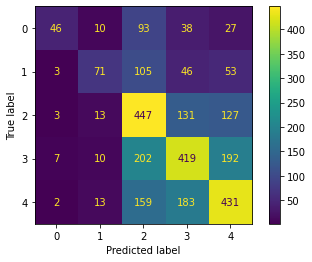

In [25]:
from sklearn.metrics import f1_score, classification_report, accuracy_score 
from sklearn.metrics import RocCurveDisplay, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from sklearn import metrics

print('Confusion Matrix')
# plot_confusion_matrix(clf, X_test, y_test)


cm = metrics.confusion_matrix(y_test_labels, test_pred, labels=nb.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=nb.classes_)
disp.plot()
plt.show()

In [27]:
print(classification_report(y_test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.75      0.21      0.33       214
           1       0.61      0.26      0.36       278
           2       0.44      0.62      0.52       721
           3       0.51      0.50      0.51       830
           4       0.52      0.55      0.53       788

    accuracy                           0.50      2831
   macro avg       0.57      0.43      0.45      2831
weighted avg       0.52      0.50      0.49      2831



## Original Naive Attempt using full documents

In [28]:
df_processed =  pp.preprocess_all(df, 'documents')

In [29]:
data = df_processed[['Lemmatized','cefr_level']]

In [30]:
data.head()

,Lemmatized,cefr_level
0,many people seen otter animal live near river ...,A2
1,dear sir read advertisement english course new...,A2
2,bicycle cheap clean way travel first bicycle m...,A2
3,bill farmer teacher dentist became writer book...,A2
4,esther left school age sixteen aunt flory gave...,A2


In [31]:
documents = data.Lemmatized
target = data.cefr_level

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(documents, target, test_size=0.3, random_state=29 )

In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB())
pipe_nb.fit(X_train, y_train)
print("Training Acc.: ", pipe_nb.score(X_train,y_train))
print("Valid Acc.: ", pipe_nb.score(X_test,y_test))

Training Acc.:  0.982532751091703
Valid Acc.:  0.3434343434343434


In [34]:
test_pred = pipe_nb.predict(X_test)

Confusion Matrix


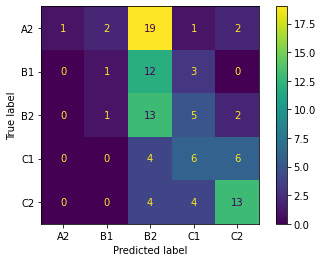

In [35]:
print('Confusion Matrix')

cm = metrics.confusion_matrix(y_test, test_pred, labels=pipe_nb.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=pipe_nb.classes_)
disp.plot()
plt.show()

In [37]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

          A2       1.00      0.04      0.08        25
          B1       0.25      0.06      0.10        16
          B2       0.25      0.62      0.36        21
          C1       0.32      0.38      0.34        16
          C2       0.57      0.62      0.59        21

    accuracy                           0.34        99
   macro avg       0.48      0.34      0.29        99
weighted avg       0.52      0.34      0.29        99



#### Take a look at the confusion matrix for the training data to see the overfitting

In [38]:
train_pred = pipe_nb.predict(X_train)

cm = metrics.confusion_matrix(y_train, train_pred, labels=pipe_nb.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=pipe_nb.classes_)
disp.plot()
plt.show()

### Three Book Excerpts for testing

In [41]:
# Twighlight Excerpt
twilight = "Tyler, trying to win back her attention, asked Lauren's opinion on a CD he held. She was distracted. I stared at the \
deep-voiced boy, taken aback, but he was looking away toward the dark forest behind us. He'd said that the Cullens didn't come here, \
but his tone had implied something more—that they weren't allowed; they were prohibited. His manner left a strange impression on me, \
and I tried toignore it without success."

In [42]:
# Great Gatsby Excerpt
gg = "He smiled understandingly-much more than understandingly. It was one of those rare smiles with a quality of eternal reassurance \
in it, that you may come across four or five times in life. It faced--or seemed to face--the whole eternal world for an instant, and \
then concentrated on you with an irresistible prejudice in your favor. It understood you just as far as you wanted to be understood, \
believed in you as you would like to believe in yourself, and assured you that it had precisely the impression of you that, at your \
best, you hoped to convey"

In [43]:
# Charlie and the Chocolate Factory Exerpt
cc = "Mr Willy Wonka can make marshmallows that taste of violets, and rich caramels that change colour every ten seconds as you suck \
them, and little feathery sweets that melt away deliciously the moment you put them between your lips. He can make chewing-gum that \
never loses its taste, and sugar balloons that you can blow up to enormous sizes before you pop them with a pin and gobble them up. \
And, by a most secret method, he can make lovely blue birds' eggs with black spots on them, and when you put one of these in your \
mouth, it gradually gets smaller and smaller until suddenly there is nothing left except a tiny little DARKRED sugary baby bird \
sitting on the tip of your tongue."

Process each excerpt in the same way as the original data

In [45]:
cc_cleaned= pp.remove_stopwords(pp.to_lower(pp.remove_punct(cc)))
charlie_test = pp.lemmatization(cc_cleaned)

In [46]:
charlie_test

'mr willy wonka make marshmallow taste violet rich caramel change colour every ten second suck little feathery sweet melt away deliciously moment put lip make chewing gum never loses taste sugar balloon blow enormous size pop pin gobble secret method make lovely blue bird egg black spot put one mouth gradually get smaller smaller suddenly nothing left except tiny little darkred sugary baby bird sitting tip tongue'

In [47]:
gg_cleaned= pp.remove_stopwords(pp.to_lower(pp.remove_punct(gg)))
gatsby_test = pp.lemmatization(gg_cleaned)

In [48]:
twil_cleaned= pp.remove_stopwords(pp.to_lower(pp.remove_punct(twilight)))
twilight_test = pp.lemmatization(twil_cleaned)

In [49]:
# Predict the three test points
print(pipe_nb.predict([charlie_test]))
print(pipe_nb.predict([gatsby_test]))
print(pipe_nb.predict([twilight_test]))

['B2']
['C2']
['B2']


#### One versus the Rest experiment with vectorized data

In [53]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

pipe_nb = make_pipeline(CountVectorizer(), OneVsRestClassifier(LogisticRegression(max_iter=1000)))
pipe_nb.fit(X_train, y_train)
print("Training Acc.: ", pipe_nb.score(X_train, y_train))
print("Valid Acc.: ", pipe_nb.score(X_test, y_test))

Training Acc.:  1.0
Valid Acc.:  0.5353535353535354


In [55]:
test_pred = pipe_nb.predict(X_test)

Confusion Matrix


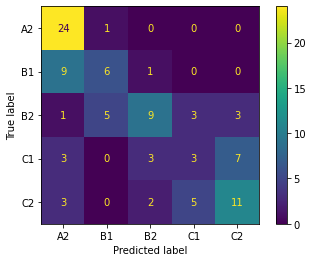

In [56]:
print('Confusion Matrix')

cm = metrics.confusion_matrix(y_test, test_pred, labels=pipe_nb.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=pipe_nb.classes_)
disp.plot()
plt.show()